STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.20.0

torch: 1.9.0a0+d819a21



- Runs on CPU or GPU (if available)

# Softmax Regression on MNIST

Implementation of softmax regression (multinomial logistic regression).

## Imports

In [2]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),  
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


/Users/sebastian/miniforge3/lib/python3.9/site-packages/torchvision-0.9.0a0-py3.9-macosx-11.0-arm64.egg/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/sebastian/Desktop/pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [5]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        avg_cost
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/234 | Cost: 2.3026
Epoch: 001/025 | Batch 050/234 | Cost: 0.7819
Epoch: 001/025 | Batch 100/234 | Cost: 0.6426
Epoch: 001/025 | Batch 150/234 | Cost: 0.5026
Epoch: 001/025 | Batch 200/234 | Cost: 0.4742
Epoch: 001/025 training accuracy: 88.06%
Time elapsed: 0.04 min
Epoch: 002/025 | Batch 000/234 | Cost: 0.4454
Epoch: 002/025 | Batch 050/234 | Cost: 0.4151
Epoch: 002/025 | Batch 100/234 | Cost: 0.4108
Epoch: 002/025 | Batch 150/234 | Cost: 0.3915
Epoch: 002/025 | Batch 200/234 | Cost: 0.3253
Epoch: 002/025 training accuracy: 89.39%
Time elapsed: 0.07 min
Epoch: 003/025 | Batch 000/234 | Cost: 0.3777
Epoch: 003/025 | Batch 050/234 | Cost: 0.3984
Epoch: 003/025 | Batch 100/234 | Cost: 0.3044
Epoch: 003/025 | Batch 150/234 | Cost: 0.3907
Epoch: 003/025 | Batch 200/234 | Cost: 0.4255
Epoch: 003/025 training accuracy: 89.85%
Time elapsed: 0.11 min
Epoch: 004/025 | Batch 000/234 | Cost: 0.3918
Epoch: 004/025 | Batch 050/234 | Cost: 0.3700
Epoch: 004/025 | Batch 100

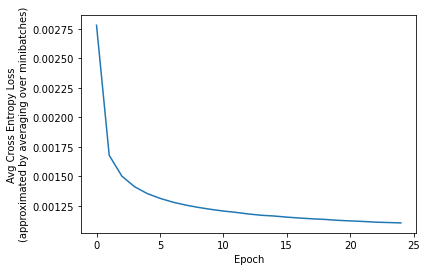

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [7]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.16%


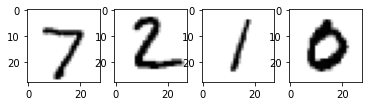

In [8]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [9]:
_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
